# <font color='green'>Building the bit-flip quantum repetition code from scratch</font>

In this chapter, we will measure the effectiveness of the quantum analogue of the classical repetition codes that we have seen so far. The procedure is similar to what we have seen so far: we will encode the quantum state that we intend to protect into the repetition code, detect errors through syndromes, decode their locations using a decoder, and determine when our decoders are unable to predict these error locations successfully.

### <font color='red'>Encoding procedure</font>

Just as a 3-bit _classical_ repetition code encodes $0 \rightarrow 000$ and $1 \rightarrow 111$, a 3-qubit _quantum_ repetition code encodes:
- $\vert0\rangle \rightarrow \vert000\rangle$
- $\vert1\rangle \rightarrow \vert111\rangle$


In the quantum setting, we also have to encode arbitrary superpositions. An arbitrary quantum state is encoded into 3 qubits as:

- $a\vert0\rangle + b\vert1\rangle \rightarrow a\vert000\rangle + b\vert111\rangle$

This encoding scheme respects the restriction placed by the no-cloning theorem ([Wootters and Zurek (1982)](https://www.nature.com/articles/299802a0)) which says that we cannot simply copy an arbitrary quantum state. To see this, note the subtle but important difference between the 3-qubit encoding above from a simple copy of the same quantum state: 

$a\vert0\rangle + b\vert1\rangle \rightarrow \left(a\vert0\rangle + b\vert1\rangle\right)\otimes\left(a\vert0\rangle + b\vert1\rangle\right)\otimes\left(a\vert0\rangle + b\vert1\rangle\right) = \alpha\vert000\rangle + \beta\vert111\rangle + \text{other terms}$,

which is disallowed by the no-cloning theorem.

### <font color='red'>Implementing the encoding procedure in Cirq</font>

The quantum circuit that implements the encoding above from 1 qubit to $n$ qubits

$a\vert0\rangle + b\vert1\rangle \rightarrow a\vert0\rangle^{\otimes n} + b\vert1\rangle^{\otimes n}$

is built as follows in Cirq.

In [1]:
from math import comb, ceil
import numpy as np
import matplotlib.pyplot as plotter; plotter.rcParams['font.family'] = 'Monospace'
import cirq, stimcirq
from myMWPM import MWPMDecoder1D

In [2]:
def create_repetition_code_encoder(n_qubits):

    qubits = cirq.LineQubit.range(n_qubits)
    circuit = cirq.Circuit()
    
    # The first qubit holds the quantum state
    for i in range(1, n_qubits):
        circuit.append(cirq.CNOT(qubits[0], qubits[i]))

    return circuit

encoder_3 = create_repetition_code_encoder(3)
print("3-qubit repetition code encoder:")
print(encoder_3)

3-qubit repetition code encoder:
0: ───@───@───
      │   │
1: ───X───┼───
          │
2: ───────X───


This quantum circuit encodes an arbitrary superposition state $a\vert0\rangle + b\vert1\rangle$ in qubit 0 into the three-qubit state $a\vert000\rangle + b\vert111\rangle$ in qubits 0, 1 and 2.

### <font color='red'>Detecting errors</font>

Let's imagine that we have a three-qubit encoded state $a\vert000\rangle + b\vert111\rangle$. Assuming that this state has been prepared as intended, we now have the task of identifying when $X$ or $Z$ errors happen on any of the three qubits. For example, the effect of an error $X_1$ on the middle qubit is

$X_1\left(a\vert000\rangle + b\vert111\rangle\right) = a\vert010\rangle + b\vert101\rangle$.

We will need some method for detecting that this specific kind of error has occurred on the middle qubit, but we also need to do this without collapsing the quantum state into an unknown state. For example, consider measuring the observable $X_1$ after the error has occurred. Then, noting that 

$\left(a\vert010\rangle + b\vert101\rangle\right) = 
\left(
a\vert0\rangle
\left(
\frac{\vert+\rangle - \vert-\rangle}{\sqrt{2}}
\right)
\vert0\rangle + 
b\vert1\rangle
\left(
\frac{\vert+\rangle + \vert-\rangle}{\sqrt{2}}
\right)
\vert1\rangle
\right) = 
a\frac{\vert0+0\rangle}{\sqrt{2}}
+b\frac{\vert1+1\rangle}{\sqrt{2}}
-a\frac{\vert0-0\rangle}{\sqrt{2}}
+b\frac{\vert1-1\rangle}{\sqrt{2}}
$

the state would collapse into $\vert+\rangle$ or $\vert-\rangle$ on qubit 1 without giving us additional information. This becomes clear when we look at the expected value of the operator: $\left(\langle010\vert a^* + \langle101\vert b^*\right)X_1\left(a\vert010\rangle + b\vert101\rangle\right) = \left(\langle010\vert a^* + \langle101\vert b^*\right)\left(a\vert000\rangle + b\vert111\rangle\right) = 0$.

To detect the error, we would need to identify an observable that will leave the state unchanged, and also reveal which error occured. It turns out that while we can find such an observable, the real power comes when we can identify a set of observables that can uniquely identify all possible $X$ errors and their locations.

#### <font color='orange'>Aside: Stabilizer formalism</font>

This is where the **stabilizer formalism** comes in -- it elegantly generalizes the classical intuition that we developed in the previous chapter. A stabilizer is an operator that leaves the quantum state unchanged when it is applied. In the language of linear algebra, the quantum state is a $+1$ eigenstate of the stabilizer $S$, and the stabilizer is said to _stabilize_ the quantum state.

For example, the state $a\vert000\rangle + b\vert111\rangle$ is stabilized by the operators $Z_1Z_2I_3$ and $I_1Z_2Z_3$ because

$Z_1Z_2I_3
\left(
a\vert000\rangle + b\vert111\rangle
\right)
=a\vert000\rangle + b\vert111\rangle
$

and

$I_1Z_2Z_3
\left(
a\vert000\rangle + b\vert111\rangle
\right)
=a\vert000\rangle + b\vert111\rangle
$

while the same state is not stabilized by the operator $Z_1I_2I_3$ since
$Z_1I_2I_3
\left(
a\vert000\rangle + b\vert111\rangle
\right)
=a\vert000\rangle - b\vert111\rangle
$

A quantum error correction practitioner would read the stabilizer $Z_1Z_2I_3$ as measuring the parity of qubits 1 and 2. If the two qubits match, $Z_1Z_2 = 1$. Otherwise, $Z_1Z_2 = -1$.

The above examples highlight that a specific quantum state can have multiple stabilizers. In fact, the elegance of the stabilizer formalism emerges when we consider multiple stabilizers working together. Different errors affect different stabilizers, creating unique patterns of measurement outcomes called **syndromes**. These syndromes act as fingerprints, allowing us to identify exactly what errors occurred.

#### <font color='orange'>An example</font>
Now, consider the three-qubit repetition code $a\vert000\rangle + b\vert111\rangle$ with $a = b = \frac{1}{\sqrt{2}}$ and the two stabilizer operators:

- $S_1 = Z_1 Z_2 I_3$ (checks the parity of qubits 1 and 2)
- $S_2 = I_1 Z_2 Z_3$ (checks the parity of qubits 2 and 3)

If we measure the two stabilizers under different possible bit-flip errors, the state remains unchanged, but the eigenvalues contain the syndromes.

| Error Type | $S_1$ | $S_2$ | Interpretation |
|------------|--------------|--------------|----------------|
| No error   | +1 | +1 | All good! |
| $X_1$ (flip qubit 1) | -1 | +1 | Bit flip error on qubit 1 |
| $X_2$ (flip qubit 2) | -1 | -1 | Bit flip error on qubit 2 |
| $X_3$ (flip qubit 3) | +1 | -1 | Bit flip error on qubit 3 |

Notice how each single-qubit error produces a unique syndrome, allowing perfect identification, __while leaving the state unchanged__! The syndrome tells us not just that an error occurred, but exactly where it happened.

#### <font color='orange'>The mathematical structure of stabilizers</font>

Stabilizers form what mathematicians call an **abelian group**:

1. **Closure**: Multiplying two stabilizers gives another stabilizer
    - If $S_1\vert\psi\rangle = \vert\psi\rangle$ and $S_2\vert\psi\rangle = \vert\psi\rangle$, then $(S_1S_2)\vert\psi\rangle = \vert\psi\rangle$

2. **Identity**: The identity operator $I$ is trivially a stabilizer
    - $I\vert\psi\rangle = \vert\psi\rangle$ for any state

3. **Commutativity**: All stabilizers in a code must commute
    - $S_1S_2 = S_2S_1$ for all stabilizers in the code

4. **Inverse elements**: Each stabilizer has eigenvalues $\pm1$, so $S^2 = I$ leaves the state unchanged.

The third property -- commutativity of stabilizers -- is particularly important because measuring one stabilizer doesn't affect the outcome of measuring another, allowing us to extract complete error information through independent measurements.

The stabilizers collectively define a **code space**—the subspace of all quantum states that are simultaneously +1 eigenstates of every stabilizer. Errors knock states out of this code space in characteristic ways, which we detect through stabilizer measurements.

### <font color='red'>Implementing error detection in Cirq</font>

From the discussion above, the stabilizers for the n-qubit repetition code $a\vert0\rangle^{\otimes n} + b\vert1\rangle^{\otimes n}$ are
- $Z_1Z_2I_3I_4\ldots$ (checks the parity of qubits 1 and 2)
- $I_1Z_2Z_3I_4\ldots$ (checks the parity of qubits 2 and 3)
- $I_1I_2Z_3Z_4\ldots$ (checks the parity of qubits 3 and 4)
- and so on.

These measurements of $Z_iZ_{i+1}$ pairs tell us where errors occurred without revealing the state itself, and leaving it intact. We can implement them in Cirq as follows, putting the syndrome measurements into ancillary qubits that flip when there is a mismatch between qubits $i$ and $i+1$.

In [3]:
def get_syndrome_measurement(qubits, ancilla_qubits):

    # For each pair of adjacent qubits, measure the ZiZi+1 stabilizer
    syndrome_measurement = []
        
    for i in range(len(qubits) - 1):
        # Extract the parity of qubits i and i+1 onto ancillary qubit i
        syndrome_measurement.append(cirq.CNOT(qubits[i], ancilla_qubits[i]))
        syndrome_measurement.append(cirq.CNOT(qubits[i+1], ancilla_qubits[i]))
    
    # Measure the ancilla qubits to extract the syndrome
    syndrome_measurement.append(cirq.measure(*ancilla_qubits, key='syndrome'))
    
    return syndrome_measurement

## <font color='blue'>Putting it all together: our first quantum error-correcting circuit</font>

Now let's combine all components into a full quantum error correction demonstration.

In [4]:
def create_full_repetition_code_circuit(n_qubits, error_probability, error_gate = cirq.X, logical_state = '0'):

    # Create qubits: data qubits for encoding, ancillary qubits for syndrome measurement
    data_qubits = cirq.LineQubit.range(n_qubits)
    ancilla_qubits = cirq.LineQubit.range(n_qubits, 2*n_qubits - 1)
    
    circuit = cirq.Circuit()

    # Step 0: Decide what quantum state we are protecting. It's either 0 or 1. Then encode it
    encoding_circuit = create_repetition_code_encoder(n_qubits)

    # logical state |0>_L = |0000...>
    # do nothing, since all data qubits start reset at |0>.
    if logical_state == '0':
        pass
        
    # logical state |1>_L = |1111...>
    # apply X gate on all data qubits since they all start reset at |0>
    if logical_state == '1':
        circuit.append(
            cirq.Moment(cirq.X(data_qubits[0]))
                       )
    
    circuit += encoding_circuit    
    
    # Step 1: Simulate noise with a Pauli error error_type occurring with probability error_probability
    circuit.append(
        cirq.Moment([
        error_gate(qubit).with_probability(error_probability) for qubit in data_qubits
                    ])
                   )
            
    # Step 2: Measure error syndrome
    circuit += get_syndrome_measurement(data_qubits, ancilla_qubits)

    # Step 3: Measure data qubits
    # we will use it to predict the initial state by correcting the final state using the syndrome data
    # When we can't predict successfully, that's a logical error
    circuit.append(cirq.measure(*data_qubits, key='data_qubits'))
    
    return circuit

Now, we can use the above function to create a full repetition code.

In [5]:
# bit-flip repetition code with 3 qubits and 2% probability of error
full_circuit = create_full_repetition_code_circuit(3, 0.02)
print(full_circuit)

0: ───@───@───X[prob=0.02]───@───────────────M('data_qubits')───
      │   │                  │               │
1: ───X───┼───X[prob=0.02]───┼───@───@───────M──────────────────
          │                  │   │   │       │
2: ───────X───X[prob=0.02]───┼───┼───┼───@───M──────────────────
                             │   │   │   │
3: ──────────────────────────X───X───┼───┼───M('syndrome')──────
                                     │   │   │
4: ──────────────────────────────────X───X───M──────────────────


Note that the top three qubits contain the protected quantum state, and the bottom two qubits contain the syndromes after one round of error detection.

## <font color='blue'>Testing the performance of our first quantum error-correcting circuit</font>

Now that we can build a complete quantum error-correcting code, let's analyze its performance. We'll create the quantum circuit, simulate errors, and see how error correction improves our ability to preserve quantum information.

Here's the gameplan. First, we will put together a function that does the following:
1. Build the repetition code circuit
2. Simulate physical errors during computation
3. Decode the syndrome information
4. Count logical errors where the decoding correction didn't really recover the logical qubit

Then, we will use this function to analyze how the logical error rate depends on the physical error rate.

In [6]:
def get_logical_error_probability_for_rep_code(n_qubits, error_probability, 
                                               logical_state = '0', error_gate = cirq.X, 
                                               n_shots = 100, simulator = stimcirq.StimSampler()):

    # step 1: build the repetition code circuit
    full_circuit = create_full_repetition_code_circuit(n_qubits, error_probability, logical_state = logical_state, error_gate = error_gate)
    
    # step 2: simulate physical errors during computation
    # print(f"Running distance {n_qubits}, bit-flip rep code, |{logical_state}>_L, error probability {error_probability}")
    # t = time.time()
    result = simulator.run(full_circuit, repetitions = n_shots)
    # elapsed = time.time() - t
    # print(f"Took {elapsed:.0f} seconds")
    
    # step 3: decode the syndrome information
    syndromes = result.measurements['syndrome']
    decoder = MWPMDecoder1D(num_qubits=n_qubits)
    decoded_syndromes = [decoder.decode(syndrome) for syndrome in syndromes]

    # step 4: count logical errors
    datas = result.measurements['data_qubits']
    logical_errors = 0

    initial_state = [int(logical_state)]*n_qubits
    for data, error_locations in zip(datas, decoded_syndromes):
        final_state = data.copy()
        for error_location in error_locations:
            final_state[error_location] = 1-final_state[error_location] # flip the bit at error_location
        if not np.array_equal(initial_state, final_state):
            logical_errors += 1

    return logical_errors * 1. / n_shots

Now, let's use the function above to analyze how the logical error probability depends on the physical error probability.

In [7]:
def get_logical_error_probability_simulated(distances, physical_errors, n_shots = 1000000, 
                                            logical_state = '0', error_gate = cirq.X,
                                            simulator = stimcirq.StimSampler()
                                           ):

    all_logical_errors = []
    for distance in distances:
        print(f"Simulating distance-{distance} repetition code circuits")
        thisdistance_logicalerrors = []
        for physical_error in physical_errors:
            logical_error = get_logical_error_probability_for_rep_code(
                                         n_qubits = distance,
                                         error_probability = physical_error,
                                         logical_state = logical_state,
                                         error_gate = error_gate,
                                         n_shots = n_shots, 
                                         simulator = simulator)
            thisdistance_logicalerrors.append(logical_error)
        all_logical_errors.append(thisdistance_logicalerrors)

    return all_logical_errors

In [8]:
distances = [3, 5, 7, 9]
physical_errors = np.logspace(-3, 0, 20)  # 10^-3 = 0.001 to 10^0 = 1 in 20 steps
logical_state = '0'
error_gate = cirq.X
n_shots = 1000000

stimSampler = stimcirq.StimSampler()
all_logical_errors = get_logical_error_probability_simulated(distances, physical_errors, 
                                                             n_shots = n_shots, simulator = stimSampler, logical_state = logical_state, error_gate = error_gate)

Simulating distance-3 repetition code circuits
Simulating distance-5 repetition code circuits
Simulating distance-7 repetition code circuits
Simulating distance-9 repetition code circuits


### <font color='red'>Analytical expression for logical error probability</font>

The analytical expression for logical error probability can be obtained by recalling that a perfect decoder would always successfully determine the locations of errors if fewer than half the qubits have flipped. We count how many such cases there can be, and use that to determine the probabilities of success and failure. When a decoding failure occurs, then we assume that it leads to a logical error.

When we have $d$ qubits, then there are $\binom{d}{0} = 1$ cases where all qubits have not flipped, $\binom{d}{1} = d$ cases where one qubit has flipped (while the others haven't), and so on. Our decoder will not fail until more than half the qubits flip. Given that each of the qubits can flip with probability $p$ independently, the probability of success is then

$$
p_\text{success} = \sum_{n_\text{flips} = 0}^{d/2} \binom{d}{n_\text{flips}}\times p^{n_\text{flips}}\times(1-p)^{d-n_\text{flips}}
$$

where $n_{\text{flips}}$ denotes the number of flipped qubits. Since the sum of all terms when $n_\text{flips}$ goes from $0$ to $d$ should be 1, the probability of failure $p_L$ is then simply one minus the above:

$$
p_L = 1-p_\text{success} =  1-\sum_{n_\text{flips} = 0}^{d/2} \binom{d}{n_\text{flips}}\times p^{n_\text{flips}}\times(1-p)^{d-n_\text{flips}} = \sum_{n_\text{flips} = \lceil \frac{d}{2}\rceil}^{d} \binom{d}{n_\text{flips}}\times p^{n_\text{flips}}\times(1-p)^{d-n_\text{flips}}
$$

where the sum now begins at the first integer above $\frac{d}{2}$, denoted by $\lceil\frac{d}{2}\rceil$ (recall that the distance $d$ is odd to enable majority voting).

When $p$ is small, we can approximate the above sum to leading order with the first term which makes the largest contribution to the probability of failure. This occurs when $n_\text{flips} = \lceil\frac{d}{2}\rceil$:

$p_L \approx \binom{d}{t} p^{t}$
for
$t = \lceil \frac{d}{2} \rceil$

This approximation also assumes independence of errors, and perfect decoding of these errors. 

For example, for distance-3 repetition codes, $p_L \approx 3p^2$.

In [9]:
def get_logical_error_probability_analytical(distances, physical_errors):

    # # method 1: small p approximation
    # all_analytical_errors = []
    # for distance in distances:
    #     t = ceil(distance / 2)
    #     analytical_errors = comb(distance, t) * physical_errors**(t)
    #     all_analytical_errors.append(analytical_errors)

    # method 2: full expression
    all_analytical_errors = []
    for distance in distances:
        analytical_error = 0
        for i in range(ceil(distance/2.), distance + 1):
            analytical_error += comb(distance, i) * physical_errors**i * (1-physical_errors)**(distance-i)
        all_analytical_errors.append(analytical_error)

    return all_analytical_errors

In [10]:
all_analytical_errors = get_logical_error_probability_analytical(distances, physical_errors)

## <font color='blue'>Plotting logical error vs physical error probabilities</font>

Now, we plot the above results to determine the conversion from physical error probabilities $p$ to logical error probabilities $p_L$ when bit-flip repetition codes of various distances are used.

In [11]:
def plot_logical_error_probabilities(distances, physical_errors, all_logical_errors, all_analytical_errors, ylim = [1e-5, 1.1]):
    
    plotter.figure(figsize=(10, 8))
    colors = plotter.cm.viridis(np.linspace(0, 0.8, len(distances)))
    
    
    plotter.loglog(physical_errors, physical_errors, label = 'Unprotected qubit',
                      linewidth=2, linestyle = '--', color='gray',
                      )
    for distance, logical_errors, analytical_errors, color in zip(distances, all_logical_errors, all_analytical_errors, colors):
        plotter.loglog(physical_errors, logical_errors, label = f'd = {distance} Simulated',
                      marker='o', linewidth=2, markersize=8,
                      color=color,
                      )
        plotter.loglog(physical_errors, analytical_errors, label = f'd = {distance} Analytical',
                      linewidth=2, linestyle = '--', color=color,
                      )
    
    plotter.legend()
    plotter.xlim([physical_errors.min(), physical_errors.max()])
    plotter.ylim(ylim)
    plotter.xlabel('Physical error probability')
    plotter.ylabel('Logical error probability')
    plotter.tight_layout()
    plotter.show()

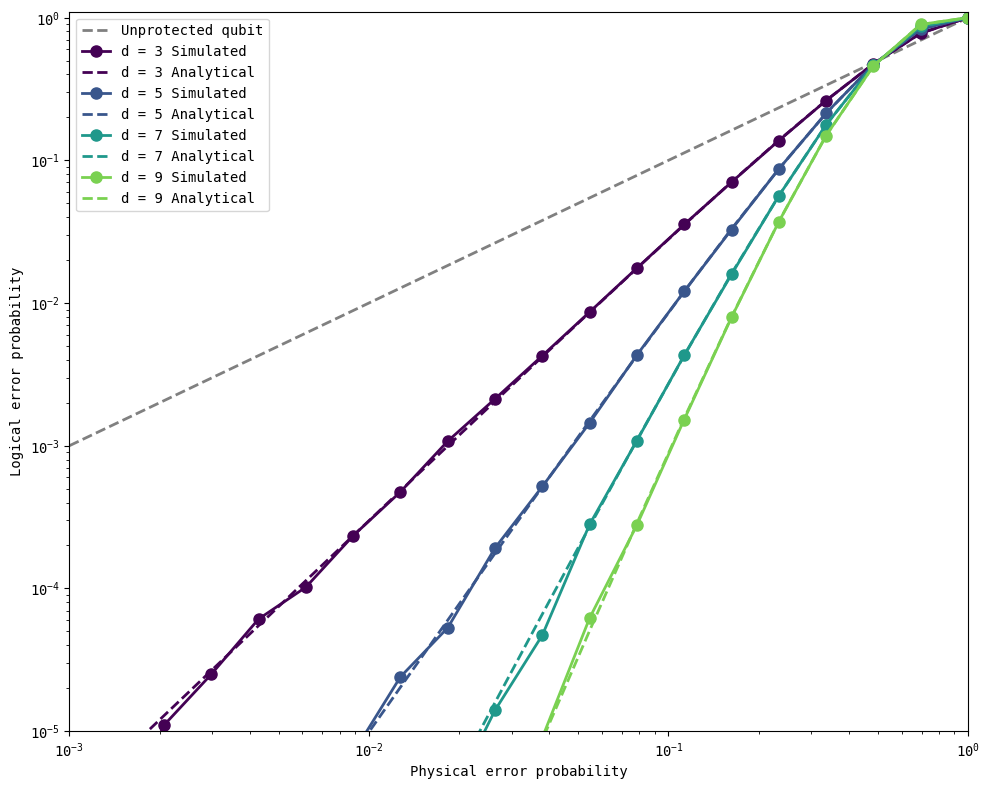

In [12]:
plot_logical_error_probabilities(
    distances,
    physical_errors,
    all_logical_errors,
    all_analytical_errors
)

## <font color='blue'>Protecting $\vert1\rangle$ from bit flips</font>

So far, our initial protected state (of qubit 0) has been $\vert0\rangle$. However, note that these results hold even if the protected state is $\vert1\rangle$.

In [13]:
logical_state = '1'

In [14]:
distances = [3, 5, 7, 9]
physical_errors = np.logspace(-3, 0, 20)
error_gate = cirq.X
n_shots = 1000000

all_logical_errors = get_logical_error_probability_simulated(distances, physical_errors, n_shots = n_shots, logical_state = logical_state, error_gate = error_gate)
all_analytical_errors = get_logical_error_probability_analytical(distances, physical_errors)

Simulating distance-3 repetition code circuits
Simulating distance-5 repetition code circuits
Simulating distance-7 repetition code circuits
Simulating distance-9 repetition code circuits


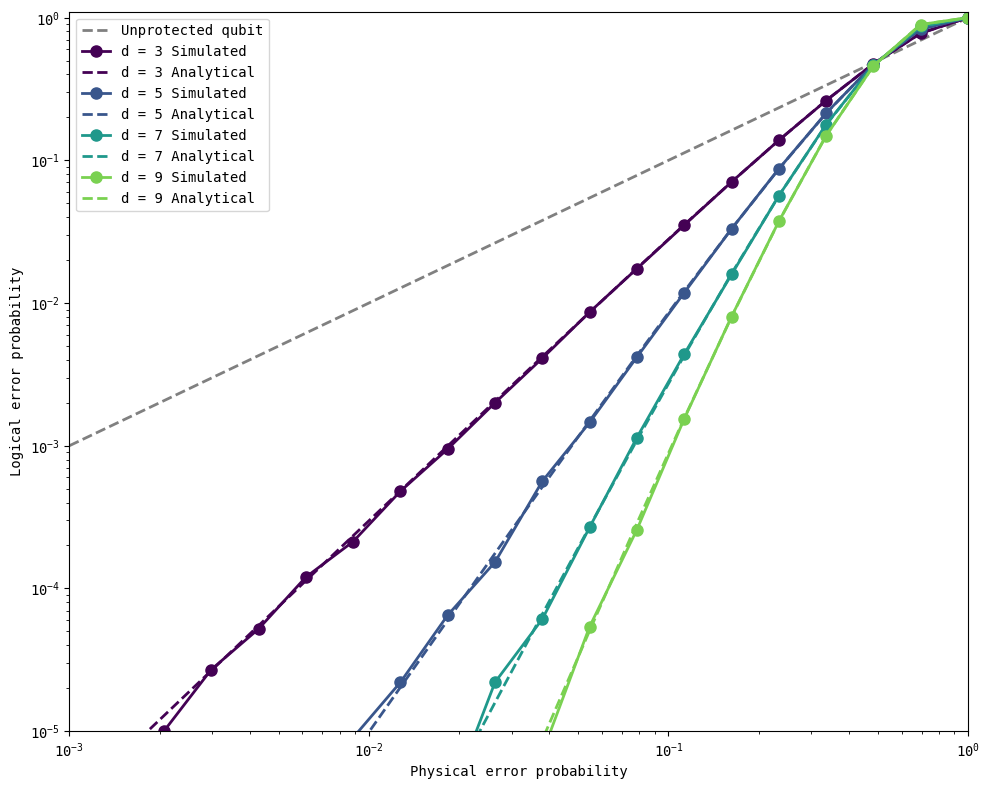

In [15]:
plot_logical_error_probabilities(distances, physical_errors, all_logical_errors, all_analytical_errors)

## <font color='blue'>Protecting against other errors</font>

So far, we have seen the effectiveness of repetition codes in correcting bit-flip $X$ errors when the starting logical states are $\vert0\rangle$ and $\vert1
\rangle$. However, note that $Z$ errors do not affect either of these states, since $Z\vert0\rangle = \vert0\rangle$ and $Z\vert1\rangle = -\vert1\rangle$, leaving the states unchanged up to a global phase.

We can see this by changing our `error_gate` parameter to `cirq.Z` below.

In [16]:
error_gate = cirq.Z
logical_state = '0'

In [17]:
distances = [3, 5, 7, 9]
physical_errors = np.logspace(-3, 0, 20)
n_shots = 1000000

all_logical_errors = get_logical_error_probability_simulated(distances, physical_errors, n_shots = n_shots, 
                                                             logical_state = logical_state, error_gate = error_gate)

Simulating distance-3 repetition code circuits
Simulating distance-5 repetition code circuits
Simulating distance-7 repetition code circuits
Simulating distance-9 repetition code circuits


In [18]:
print(all_logical_errors)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [19]:
error_gate = cirq.Z
logical_state = '1'

In [20]:
distances = [3, 5, 7, 9]
physical_errors = np.logspace(-3, 0, 20)
n_shots = 1000000

all_logical_errors = get_logical_error_probability_simulated(distances, physical_errors, n_shots = n_shots, 
                                                             logical_state = logical_state, error_gate = error_gate)

Simulating distance-3 repetition code circuits
Simulating distance-5 repetition code circuits
Simulating distance-7 repetition code circuits
Simulating distance-9 repetition code circuits


In [21]:
print(all_logical_errors)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


These results show that a $Z$ error (phase flip) does not affect the logical $\vert0\rangle$ and $\vert1\rangle$ states, and is therefore not detected by our bit-flip repetition codes. 

## <font color='blue'>Summary</font>

In this tutorial, you learned how bit-flip repetition codes can be implemented in the quantum scenario, analogous to the classical majority voting setting. These repetition codes protect against bit-flip errors, whose effect is to flip between the two logical states in the computational basis ($\vert0\rangle$ and $\vert1\rangle$). We also saw that $Z$ errors (phase flips) do not affect these logical states.

However, phase flips do affect superposition states, since $Z\vert+\rangle = \vert-\rangle$ and $Z\vert-\rangle = \vert+\rangle$. In fact, since the effect of a $Z$ error is to flip between the states $\vert+\rangle$ and $\vert-\rangle$, it acts exactly as a bit-flip in the Hadamard basis (where $\vert+\rangle$ and $\vert-\rangle$ are equivalent to $\vert0\rangle$ and $\vert1\rangle$ in the computational basis). For this reason, phase flips do show up when the starting state is in the Hadamard basis. In the next chapter, we will demonstrate phase-flip repetition codes, and adapt our bit-flip repetition code above to account for these kinds of errors.In the next chapter, you will learn how to protect against phase-flip errors.

---
### Version History
- v0: Sep 12, 2025, [github/@aasfaw](https:github.com/aasfaw)
- v1: Sep 13, 2025, [github/@aasfaw](https:github.com/aasfaw) cleanup + readability improvements with collapsed cells